In [28]:
import numpy as np
import matplotlib.pyplot as plt

In [18]:
# テキストからコーパスを作成
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
        
    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

# コーパスから共起行列を作成
def create_co_matrix(corpus, vocab_size, window_size = 1):
    corpus_size = len(corpus)
    co_matrix = np.zeros([vocab_size, vocab_size], dtype = np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
            
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
    
    return co_matrix

def cos_similarity(x, y, eps=1e-8):
    # xの正規化
    nx = x / (np.sqrt(np.sum(x**2)) + eps)
    # yの正規化
    ny = y / (np.sqrt(np.sum(y**2))+ eps)
    return np.dot(nx, ny)

def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    # クエリを取り出す
    if query not in word_to_id:
        print('%s is not found' % query)
        return

    print('\n[query]' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    # コサイン類似度を算出
    vocab_size = len(word_to_id)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    # コサイン類似度の結果から、その値を高い順に出力
    count = 0
    # argsort()：配列を小さい順に並び替えてそのindexを返す
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print('%s: %s' % (id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return 


In [5]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
co_matrix = create_co_matrix(corpus, len(word_to_id))

In [17]:
c0 = co_matrix[word_to_id['you']]
c1 = co_matrix[word_to_id['i']]
cos_similarity(c0, c1)

[0 1 0 0 0 0 0]


0.7071067691154799

In [19]:
most_similar('you', word_to_id, id_to_word, co_matrix, top=5)


[query]you
goodbye: 0.7071067691154799
i: 0.7071067691154799
hello: 0.7071067691154799
say: 0.0
and: 0.0


- カウントベースの手法の課題
    - カウントベースの手法は共起回数に依存している
    - 「car」と「drive」は明らかに関連性が強いが、カウントベースでやってしまうと「car」と「the」の方が関連性が高いと出てしまう
    - 頻度での評価には限界がある

- 上記問題を解決するために相互情報量（Pointwise Mutual Information : PMI）を使う
    - $ PMI(x, y) = \log_2 \frac{P(x, y)}{P(x)P(y)}$
    - 自然言語の例に当てはめた式が下記
        - C：共起行列、N：コーパスに含まれる単語数
        - $ PMI(x, y) = \log_2 \frac{C(x, y) \times N}{C(x)C(y)}$

- PMIの課題
    - ２つの単語で共起する回数が0の場合、$\log_2 0 = - \infty$  になる
    - そのため、実戦では正の相互情報量（Positive PMI）を使う
        - $PPMI(x, y) = max(0, PMI(x, y))$

In [22]:
# C：共起行列
# verbose：進行状況を出力するかどうかを決めるフラグ
def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=1)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N /(S[i]*S[j]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total//100+1) == 0:
                    print('%.lf%% done' % (100*cnt/total))
    return M

In [27]:
W = ppmi(co_matrix)
print(W)

[[0.        1.8073549 0.        0.        0.        0.        0.       ]
 [1.8073549 0.        0.8073549 0.        0.8073549 0.8073549 0.       ]
 [0.        0.8073549 0.        1.8073549 0.        0.        0.       ]
 [0.        0.        1.8073549 0.        1.8073549 0.        0.       ]
 [0.        0.8073549 0.        1.8073549 0.        0.        0.       ]
 [0.        0.8073549 0.        0.        0.        0.        2.807355 ]
 [0.        0.        0.        0.        0.        2.807355  0.       ]]


- PPMIにも課題がある
    - コーパスの語彙数が増えるにつれて、各単語のベクトルの次元数も増える
    - One-hotなので、次元は増えても大半は意味を持たない
        - ノイズに弱い
        - 頑健性に乏しい
    - ベクトルの次元削減で対応する
    - 特異値分解（Singular Value Decomposition：SVD）

In [29]:
U, S, V = np.linalg.svd(W)

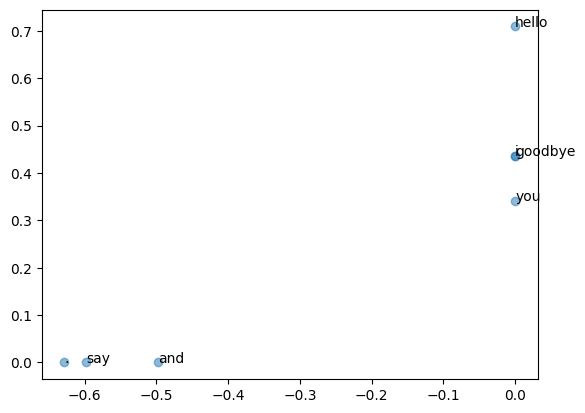

In [31]:
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:, 0], U[:, 1], alpha= 0.5)
plt.show()